# Network Community Detection

## Brain Network Community Detection

#### Load brain network graph data to Network dataclass

In [1]:
from QHyper.problems.community_detection import BrainNetwork


path = "../QHyper/problems/network_communities/brain_community_data"
data_name = "Edge_AAL90_Binary"

brain_network = BrainNetwork(input_data_dir=path, input_data_name=data_name)

<class 'networkx.utils.decorators.argmap'> compilation 5:5: FutureWarning: modularity_matrix will return a numpy array instead of a matrix in NetworkX 3.0.


#### Run the problem with DQM for k different communities to detect, each r times

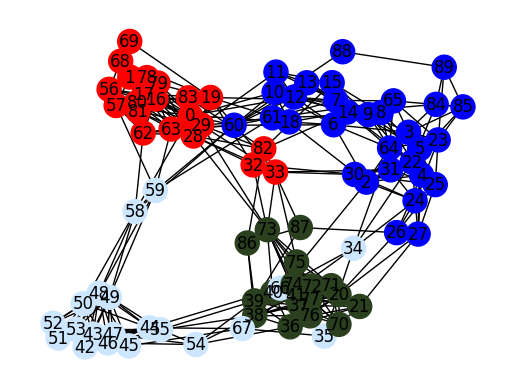

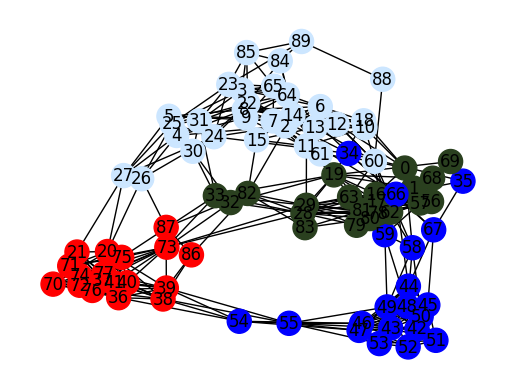

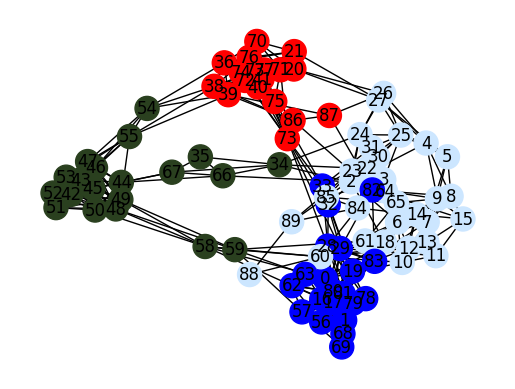

In [428]:
from QHyper.solvers.dqm import DQM
from QHyper.problems.network_communities.utils import ResultsFrame, draw_communities, draw_communities_from_graph, communities_to_csv, results_to_csv
from QHyper.problems.community_detection import CommunityDetectionProblem
import time
import networkx.algorithms.community as nx_comm


folder = "./demo_output"
data_name = 'Edge_AAL90_Binary'

N_communities = [4]
runs = range(3)
qa_results_dict = {k: ResultsFrame() for k in N_communities}
louvain_results_dict = {k: ResultsFrame() for k in N_communities}

for k in N_communities:
    brain_problem = CommunityDetectionProblem(brain_network, k)
    qa_results = qa_results_dict[k]
    louvain_results = louvain_results_dict[k]
    
    for r in runs:
        # Quantum
        brain_dqm = DQM(brain_problem, time=5)
        brain_dqm_sampleset = brain_dqm.solve_from_graph()
        lowest_sample = brain_dqm_sampleset.first

        qa_results.samples.append(lowest_sample.sample)
        qa_results.energies.append(lowest_sample.energy)
        qa_results.run_times.append(brain_dqm_sampleset.info["run_time"])
        qa_results.calculate_append_communities(lowest_sample.sample, k)
        qa_results.calculate_append_communities_counts(lowest_sample.sample, k)
        qa_results.modularity_scores.append(nx_comm.modularity(brain_problem.G, qa_results.communities[r]))

        # Classical
        start = time.time()
        louvain_communities = nx_comm.louvain_communities(brain_problem.G, resolution=0.5, seed=None)  # , seed=123)
        end = time.time()
        sample_like = louvain_results.louvain_communities_to_sample_like(louvain_communities)
        
        louvain_results.samples.append(sample_like)
        louvain_results.energies.append(None)
        louvain_results.run_times.append(end - start)
        louvain_results.calculate_append_communities(sample_like, len(louvain_communities))
        louvain_results.calculate_append_communities_counts(sample_like, len(louvain_communities))
        louvain_results.modularity_scores.append(nx_comm.modularity(brain_problem.G, louvain_results.communities[r]))

        # Save results
        # Draw qa comm graph in each run
        qa_img_path = f"{folder}/{data_name}graph{k}_{r}.png"
        draw_communities_from_graph(brain_problem, qa_results.samples[r], qa_img_path)
        # Save current qa communities to csv
        qa_clustering_path = f"{folder}/{data_name}clustering{k}_{r}.csv"
        communities_to_csv(brain_problem, qa_results.samples[r], qa_clustering_path)

    results_path = f"{folder}/{data_name}_N{k}runs.csv"
    results_to_csv(qa_results, louvain_results, results_path)

#### Let's take a look at the partitioning stats

In [429]:
import pandas as pd

df_qa = pd.DataFrame.from_dict(qa_results_dict[4].__dict__)
df_lou = pd.DataFrame.from_dict(louvain_results_dict[4].__dict__)

In [441]:
df_qa

,samples,run_times,communities,communities_counts,N_communities,modularity_scores,energies
0,"{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...",5133133,"[{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ...","[31.0, 21.0, 18.0, 20.0]",4,0.642478,-269.148418
1,"{0: 2, 1: 2, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: ...",5107838,"[{34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, ...","[20.0, 18.0, 21.0, 31.0]",4,0.642478,-269.148418
2,"{0: 0, 1: 0, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: ...",5097341,"[{0, 1, 16, 17, 19, 28, 29, 32, 33, 56, 57, 62...","[21.0, 18.0, 20.0, 31.0]",4,0.642478,-269.148418


In [442]:
df_lou

,samples,run_times,communities,communities_counts,N_communities,modularity_scores,energies
0,"{0: 0, 1: 2, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...",0.004999,"[{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[32.0, 18.0, 20.0, 20.0]",4,0.641119,None
1,"{0: 3, 1: 2, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: ...",0.004998,"[{34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, ...","[20.0, 18.0, 20.0, 32.0]",4,0.641119,None
2,"{0: 0, 1: 3, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...",0.005106,"[{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[36.0, 18.0, 16.0, 20.0]",4,0.637254,None


As we can see, QA achieved higher modularity scores in each round.

In [590]:
nodes = list(df_qa["samples"].values[0].keys())

qa_values_r0 = list(df_qa["samples"].values[0].values())
qa_values_r1 = list(df_qa["samples"].values[1].values())
qa_values_r2 = list(df_qa["samples"].values[2].values())

lou_values_r0 = list(df_lou["samples"].values[0].values())
lou_values_r1 = list(df_lou["samples"].values[1].values())
lou_values_r2 = list(df_lou["samples"].values[2].values())

In [591]:
qa_values_r0 = list(df_qa.samples.values[0].values())
qa_values_r1 = list(df_qa.samples.values[1].values())
qa_values_r2 = list(df_qa.samples.values[2].values())

qa_comms_r0 = df_qa.communities.values[0]
qa_comms_r1 = df_qa.communities.values[1]
qa_comms_r2 = df_qa.communities.values[2]

qa_samples_r0 = df_qa.samples.values[0]
qa_samples_r1 = df_qa.samples.values[1]
qa_samples_r2 = df_qa.samples.values[2]

In [602]:
def jaccard(nodeset1, nodeset2):
    intersection = len(list(nodeset1.intersection(nodeset2)))
    union = (len(nodeset1) + len(nodeset2)) - intersection
    return float(intersection) / union


def standarize_sample_cluster_ordering(sample, ref_sample, communities, ref_communities, similarity_threshold=0.5) -> tuple((dict, list)):
    k = len(communities)
    # renamed_sample = {}
    rename = {}
    # rename = {node: value for node, value in sample.items()}
    for i in range(k):
        # comm = communities[i]
        ref_comm = ref_communities[i]
        for j in range( k):
            # ref_comm = ref_communities[j]
            comm = communities[j]
            jacc = jaccard(comm, ref_comm)
            if jacc == 1:
                # rename[j] = i
                intersection_nodes = comm.intersection(ref_comm)
                # print(jacc, intersection_nodes)
                rep = intersection_nodes.pop()
                print(rep)
                rename[j] = ref_sample[rep]
                # for node in intersection_nodes:
                #     # renamed_sample[node] = rename[ref_sample[rep]]
                #     rename[node] = ref_sample[rep]

    # print(rename)
    renamed_sample = {node:rename[clus] for node, clus in sample.items()}
    # renamed_sample = {node: rename[node] for node in sample.keys()}

    print(renamed_sample)
    renamed_communities = []
    for clus in range(k):
        comm = []
        for i in renamed_sample:
            if renamed_sample[i] == clus:
                comm.append(i)
        renamed_communities.append(set(comm))

    # print(f"rename dict: {rename}\n\n")

    return renamed_sample, renamed_communities

64
0
70
66
{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 1, 20: 2, 21: 2, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 1, 30: 0, 31: 0, 32: 1, 33: 1, 34: 3, 35: 3, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 3, 55: 3, 56: 1, 57: 1, 58: 3, 59: 3, 60: 0, 61: 0, 62: 1, 63: 1, 64: 0, 65: 0, 66: 3, 67: 3, 68: 1, 69: 1, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 0, 85: 0, 86: 2, 87: 2, 88: 0, 89: 0}
2
0
36
34
{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 1, 20: 2, 21: 2, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 1, 30: 0, 31: 0, 32: 1, 33: 1, 34: 3, 35: 3, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52:

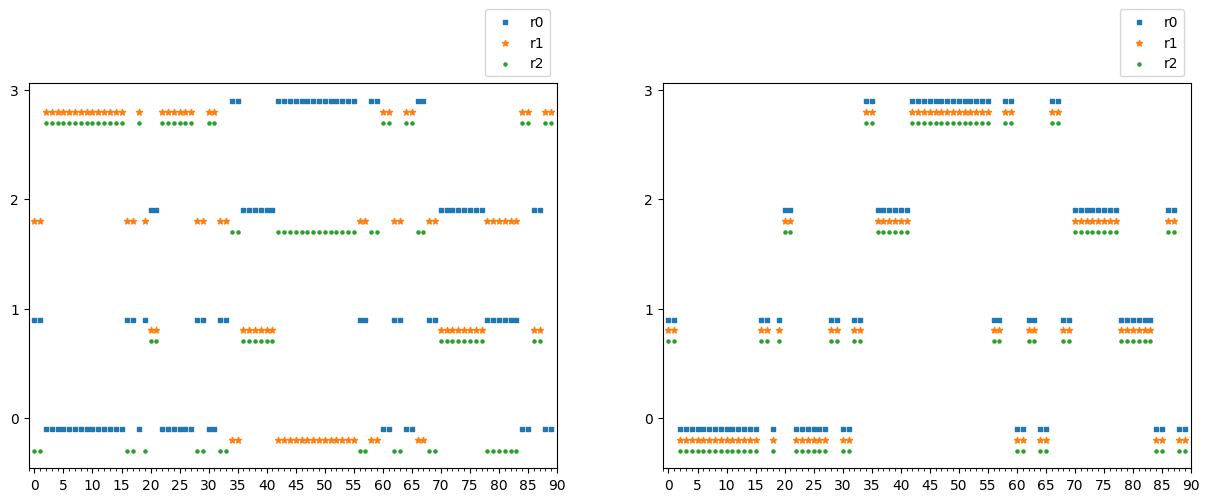

In [603]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


f, ax = plt.subplots(1, 2, figsize=(15, 5))

# Set tickers
x_major_ticker = mpl.ticker.MultipleLocator(5)
x_minor_ticker = mpl.ticker.MultipleLocator(1)

# Set text annotations
# ax.set_title("QA partitioning results in 3 rounds")
# ax.set_xlabel("Network graph nodes")
# ax.set_ylabel("Detected communities partitioning")

# Set ticks, lims, tickers
for a in ax:
    a.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]);
    a.set_yticks(np.unique(qa_values_r0).flatten());
    a.set_xlim(-1, 90);
    a.xaxis.set_major_locator(x_major_ticker)
    a.xaxis.set_minor_locator(x_minor_ticker)

# Scatter
values = [qa_values_r0, qa_values_r1, qa_values_r2]
samples = [qa_samples_r0, qa_samples_r1, qa_samples_r2]
communities = [qa_comms_r0, qa_comms_r1, qa_comms_r2]

ref_sample = qa_samples_r0
ref_comm = qa_comms_r0

standarized_ordering = [renamed_sample for renamed_sample, _ in [standarize_sample_cluster_ordering(sam, ref_sample, comm, ref_comm) for sam, comm in zip(samples, communities)]]
standarized_values = [v.values() for v in [s for s in standarized_ordering]]

off_unit = 0.1
offsets = [off_unit*i for i in [1,2,3]]
markers = ["s", "*", "o"]
labels=["r0", "r1", "r2"]
ss=[5,20,5]


for i, vals in enumerate(values):
    offset, s, m, l = offsets[i], ss[i], markers[i], labels[i]
    ax[0].scatter(nodes, [v-offset for v in vals], s=s, marker=m, label=l)
ax[0].legend(loc=4, bbox_to_anchor=(1,1));

for i, vals in enumerate(standarized_values):
    offset, s, m, l = offsets[i], ss[i], markers[i], labels[i]
    ax[1].scatter(nodes, [v-offset for v in vals], s=s, marker=m, label=l)
ax[1].legend(loc=4, bbox_to_anchor=(1,1));

64
0
70
66
{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 1, 20: 2, 21: 2, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 1, 30: 0, 31: 0, 32: 1, 33: 1, 34: 3, 35: 3, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 3, 55: 3, 56: 1, 57: 1, 58: 3, 59: 3, 60: 0, 61: 0, 62: 1, 63: 1, 64: 0, 65: 0, 66: 3, 67: 3, 68: 1, 69: 1, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 0, 85: 0, 86: 2, 87: 2, 88: 0, 89: 0}
2
0
36
34
{0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 1, 20: 2, 21: 2, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 1, 30: 0, 31: 0, 32: 1, 33: 1, 34: 3, 35: 3, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52:

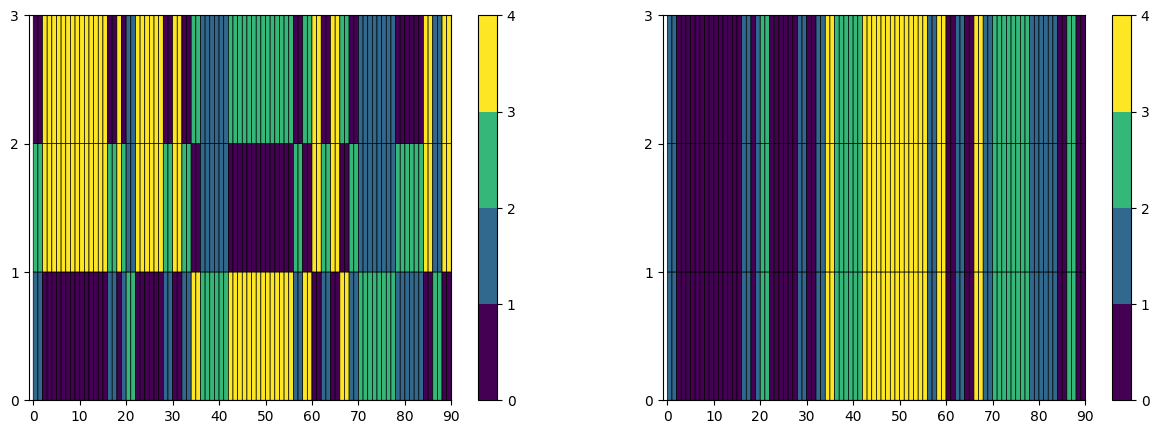

In [604]:
# ax.scatter(nodes, qa_values_r0, s=5, marker='s', label="r0");
# ax.scatter(nodes, [val-0.07 for val in qa_values_r1], s=20, marker="*", label="r1");
f, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax.scatter(nodes, qa_values_r0)

xv, yv = np.meshgrid(nodes, [0, 1, 2])

values = [qa_values_r0, qa_values_r1, qa_values_r2]
samples = [qa_samples_r0, qa_samples_r1, qa_samples_r2]
communities = [qa_comms_r0, qa_comms_r1, qa_comms_r2]

ref_sample = qa_samples_r0
ref_comm = qa_comms_r0

standarized_ordering = [renamed_sample for renamed_sample, _ in [standarize_sample_cluster_ordering(sam, ref_sample, comm, ref_comm) for sam, comm in zip(samples, communities)]]
standarized_values = [v.values() for v in [s for s in standarized_ordering]]

z = np.array([[val[n] for n in nodes] for val in values])
heatmap = ax[0].pcolor(z, edgecolors='k', linewidths=0.5)
plt.colorbar(heatmap, boundaries=[0,1,2,3,4], values=[0,1,2,3])
ax[0].set_yticks(np.unique(z));
ax[0].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]);
ax[0].set_xlim(-1, 90);

print(standarized_values)
for el in standarized_values:
    print(list(el))
z = np.array([[list(val)[n] for n in nodes] for val in standarized_values])
heatmap = ax[1].pcolor(z, edgecolors='k', linewidths=0.5)
plt.colorbar(heatmap, boundaries=[0,1,2,3,4], values=[0,1,2,3])
ax[1].set_yticks(np.unique(z));
ax[1].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]);
ax[1].set_xlim(-1, 90);

## Karate Club Problem

Network representation

In [508]:
from QHyper.problems.community_detection import KarateClubNetwork


karate_club_network = KarateClubNetwork

Louvain community detection algorithm (networkx impl.)

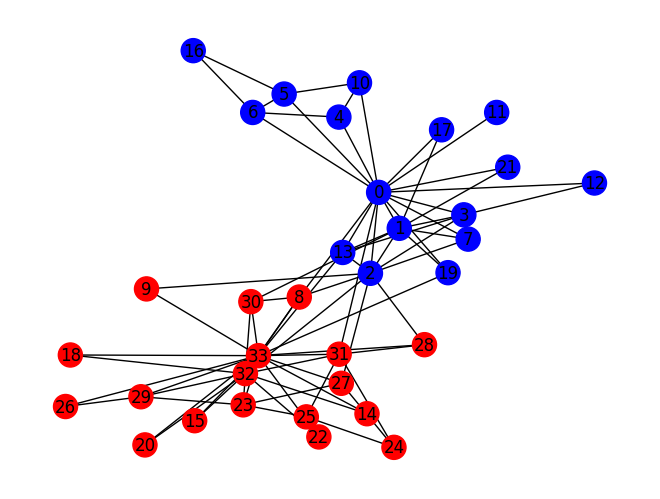

In [509]:
from networkx import community as nx_comm
import networkx as nx


lcda_communities = nx_comm.louvain_communities(
    karate_club_network.graph, seed=5345, resolution=0.5
) # seed=None

color_map = []
for node in karate_club_network.graph:
    if node in lcda_communities[0]:
        color_map.append("blue")
    else:
        color_map.append("red")

nx.draw(karate_club_network.graph, node_color=color_map, with_labels=True)

### Create Community Detection Problem instance

In [510]:
from QHyper.problems.community_detection import CommunityDetectionProblem


karate_club_problem = CommunityDetectionProblem(karate_club_network, N_communities=2)
karate_club_problem.objective_function

-0.0769230769230769*x0*x1 - 0.692307692307692*x0*x10 - 0.897435897435897*x0*x11 - 0.794871794871795*x0*x12 - 0.487179487179487*x0*x13 + 0.205128205128205*x0*x14 + 0.205128205128205*x0*x15 + 0.205128205128205*x0*x16 - 0.794871794871795*x0*x17 + 0.205128205128205*x0*x18 - 0.692307692307692*x0*x19 + 0.0256410256410255*x0*x2 + 0.205128205128205*x0*x20 - 0.794871794871795*x0*x21 + 0.205128205128205*x0*x22 + 0.512820512820513*x0*x23 + 0.307692307692308*x0*x24 + 0.307692307692308*x0*x25 + 0.205128205128205*x0*x26 + 0.41025641025641*x0*x27 + 0.307692307692308*x0*x28 + 0.41025641025641*x0*x29 - 0.384615384615385*x0*x3 + 0.41025641025641*x0*x30 - 0.384615384615385*x0*x31 + 1.23076923076923*x0*x32 + 1.74358974358974*x0*x33 - 0.692307692307692*x0*x4 - 0.58974358974359*x0*x5 - 0.58974358974359*x0*x6 - 0.58974358974359*x0*x7 - 0.487179487179487*x0*x8 + 0.205128205128205*x0*x9 + 0.173076923076923*x1*x10 + 0.0576923076923077*x1*x11 + 0.115384615384615*x1*x12 - 0.711538461538462*x1*x13 + 0.115384615384

##### With DQM

##### dqm.solve() - use objective function as sympy expr. in converter.to_dqm

In [511]:
from QHyper.solvers.dqm import DQM


karate_dqm = DQM(karate_club_problem, time=5)
karate_sampleset_dqm = karate_dqm.solve()

In [512]:
karate_dqm_sample = karate_sampleset_dqm.first

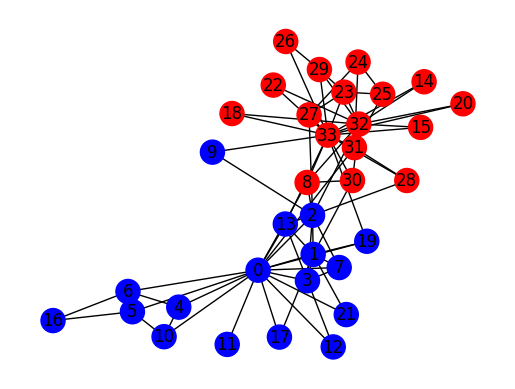

In [235]:
from QHyper.problems.network_communities.utils import ResultsFrame, draw_communities, draw_communities_from_graph


folder = "./demo_output"
data_name = "karate_club"
path = f"{folder}/{data_name}.png"

draw_communities(karate_club_problem, karate_dqm_sample.sample, path)

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

# Set tickers
x_major_ticker = mpl.ticker.MultipleLocator(5)
x_minor_ticker = mpl.ticker.MultipleLocator(1)

# Set text annotations
# ax.set_title("QA partitioning results in 3 rounds")
# ax.set_xlabel("Network graph nodes")
# ax.set_ylabel("Detected communities partitioning")

# Set ticks, lims, tickers
for a in ax:
    a.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]);
    a.set_yticks(np.unique(qa_values_r0).flatten());
    a.set_xlim(-1, 90);
    a.xaxis.set_major_locator(x_major_ticker)
    a.xaxis.set_minor_locator(x_minor_ticker)

# Scatter
values = [karate_dqm_sample.sample.values()]
samples = [karate_dqm_sample.sample]
communities = [communities_from_sample(samples[0], 2)]

ref_sample = valaues[0]
ref_comm = qa_comms_r0

standarized_ordering = [renamed_sample for renamed_sample, _ in [standarize_sample_cluster_ordering(sam, ref_sample, comm, ref_comm) for sam, comm in zip(samples, communities)]]
standarized_values = [v.values() for v in [s for s in standarized_ordering]]

off_unit = 0.1
offsets = [off_unit*i for i in [1,2,3]]
markers = ["s", "*", "o"]
labels=["r0", "r1", "r2"]
ss=[5,20,5]


for i, vals in enumerate(values):
    offset, s, m, l = offsets[i], ss[i], markers[i], labels[i]
    ax[0].scatter(nodes, [v-offset for v in vals], s=s, marker=m, label=l)
ax[0].legend(loc=4, bbox_to_anchor=(1,1));

for i, vals in enumerate(standarized_values):
    offset, s, m, l = offsets[i], ss[i], markers[i], labels[i]
    ax[1].scatter(nodes, [v-offset for v in vals], s=s, marker=m, label=l)
ax[1].legend(loc=4, bbox_to_anchor=(1,1));

Differences with Louvain algorithm

In [514]:
def communities_from_sample(sample, N_communities: int) -> set:
    communities = []
    for k in range(N_communities):
        comm = []
        for i in sample:
            if sample[i] == k:
                comm.append(i)
        communities.append(set(comm))

    return communities

In [529]:
karate_communities_dqm = communities_from_sample(karate_dqm_sample.sample, 2)

lcda_communities_xs = [
    {"x" + str(n) for n in cluster} for cluster in lcda_communities
]

print("\nLCDA")
print(f"comm. 0: {lcda_communities_xs[0]}")
print(f"comm. 1: {lcda_communities_xs[1]}")

print("\nDQM")
print(f"comm. 0: {karate_communities_dqm[0]}")
print(f"comm. 1: {karate_communities_dqm[1]}")

print("\nDiff.:")
print(karate_communities_dqm[0].difference(lcda_communities_xs[0]))



LCDA
comm. 0: {'x17', 'x5', 'x10', 'x3', 'x19', 'x2', 'x0', 'x11', 'x1', 'x13', 'x12', 'x16', 'x7', 'x4', 'x6', 'x21'}
comm. 1: {'x25', 'x20', 'x29', 'x9', 'x23', 'x30', 'x33', 'x22', 'x28', 'x26', 'x27', 'x31', 'x32', 'x15', 'x18', 'x14', 'x8', 'x24'}

DQM
comm. 0: {'x17', 'x5', 'x10', 'x3', 'x9', 'x19', 'x2', 'x0', 'x11', 'x1', 'x13', 'x12', 'x16', 'x7', 'x4', 'x6', 'x21'}
comm. 1: {'x25', 'x20', 'x29', 'x30', 'x23', 'x33', 'x22', 'x28', 'x26', 'x27', 'x31', 'x32', 'x15', 'x18', 'x14', 'x8', 'x24'}

Diff.:
{'x9'}


{'x0': 0, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 0, 'x6': 0, 'x7': 0, 'x8': 1, 'x9': 0, 'x10': 0, 'x11': 0, 'x12': 0, 'x13': 0, 'x14': 1, 'x15': 1, 'x16': 0, 'x17': 0, 'x18': 1, 'x19': 0, 'x20': 1, 'x21': 0, 'x22': 1, 'x23': 1, 'x24': 1, 'x25': 1, 'x26': 1, 'x27': 1, 'x28': 1, 'x29': 1, 'x30': 1, 'x31': 1, 'x32': 1, 'x33': 1}
[[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]]


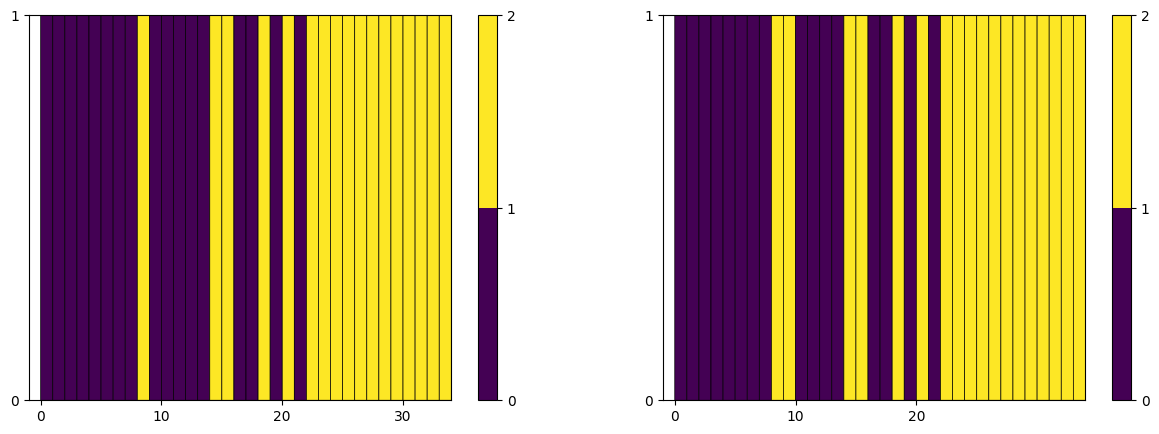

In [584]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax.scatter(nodes, qa_values_r0)
nodes = karate_club_problem.G.nodes
xv, yv = np.meshgrid(nodes, [0, 1, 2])

values = [karate_dqm_sample.sample.values()]
samples = [karate_dqm_sample.sample]
communities = [communities_from_sample(samples[0], 2)]

ref_sample = values[0]
ref_comm = communities[0]

standarized_ordering = [renamed_sample for renamed_sample, _ in [standarize_sample_cluster_ordering(sam, ref_sample, comm, ref_comm) for sam, comm in zip(samples, communities)]]
standarized_values = [v.values() for v in [s for s in standarized_ordering]]

z = np.array([[list(val)[n] for n in nodes] for val in values])
heatmap = ax[0].pcolor(z, edgecolors='k', linewidths=0.5)
plt.colorbar(heatmap, boundaries=[0,1,2], values=[0,1])
ax[0].set_yticks(np.unique(z));
ax[0].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]);
ax[0].set_xlim(-1, 34);


lcda_communities_xs = [
    {"x" + str(n) for n in cluster} for cluster in lcda_communities
]
lcda_sample_like = ResultsFrame().louvain_communities_to_sample_like(lcda_communities_xs)
z = np.array([[val["x" + str(n)] for n in nodes] for val in [lcda_sample_like]])
print(z)
heatmap = ax[1].pcolor(z, edgecolors='k', linewidths=0.5)
plt.colorbar(heatmap, boundaries=[0,1,2], values=[0,1])
ax[1].set_yticks(np.unique(z));
ax[1].set_xticks([0, 10, 20]);
ax[1].set_xlim(-1, 34);

#### dqm.solve_from_graph() - use graph iteration instead of sympy expr. in converter.to_dqm

In [65]:
karate_sampleset_from_graph = karate_dqm.solve_from_graph()

In [66]:
karate_sampleset_dqm_from_graph = karate_sampleset_from_graph.first

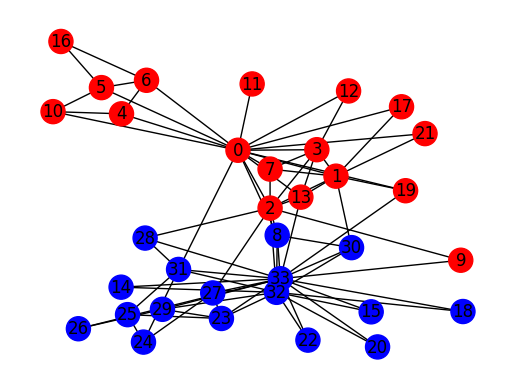

In [67]:
path = f"{folder}/{data_name}_dqm_from_graph.png"
draw_communities_from_graph(karate_club_problem, karate_sampleset_dqm_from_graph.sample, path)

#### The same results obtained with .to_dqm() and .to_dqm_from_graph()

In [1]:
karate_communities_dqm_from_graph = communities_from_sample(karate_sampleset_dqm_from_graph.sample, 2)

karate_communities_dqm_from_graph_xs = [
    {"x" + str(n) for n in cluster} for cluster in karate_communities_dqm_from_graph
]

print("\nDQM")
print(f"comm. 0: {karate_communities_dqm[0]}")
print(f"comm. 1: {karate_communities_dqm[1]}")

print("\nDQM from graph")
print(f"comm. 0: {karate_communities_dqm_from_graph_xs[0]}")
print(f"comm. 1: {karate_communities_dqm_from_graph_xs[1]}")

print("\nDiff.:")
print(karate_communities_dqm_from_graph_xs[1].difference(karate_communities_dqm[0]))
print("Same results")

NameError: name 'communities_from_sample' is not defined

### CQM

In [82]:
from QHyper.solvers.cqm import CQM


karate_cqm = CQM(karate_club_problem, time=5)
karate_cqm_sample = karate_cqm.solve()

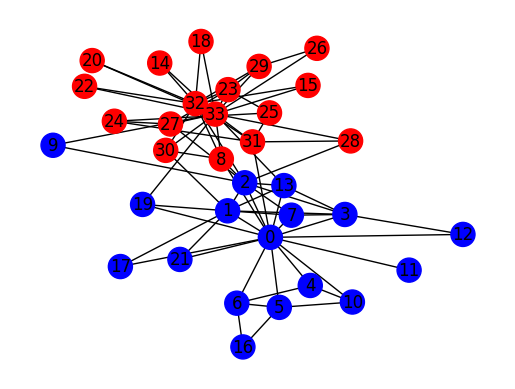

In [92]:
path = f"{folder}/{data_name}_cqm.png"
draw_communities(karate_club_problem, karate_cqm_sample, path)

Comparison with Louvain algorithm

In [94]:
karate_communities_cqm = communities_from_sample(karate_cqm_sample, 2)

lcda_communities_xs = [
    {"x" + str(n) for n in cluster} for cluster in lcda_communities
]

print("\nLCDA")
print(f"comm. 0: {lcda_communities_xs[0]}")
print(f"comm. 1: {lcda_communities_xs[1]}")

print("\nCQM")
print(f"comm. 0: {karate_communities_cqm[0]}")
print(f"comm. 1: {karate_communities_cqm[1]}")

print("\nDiff.:")
print(karate_communities_cqm[0].difference(lcda_communities_xs[0]))


LCDA
comm. 0: {'x13', 'x2', 'x0', 'x19', 'x21', 'x5', 'x6', 'x4', 'x17', 'x7', 'x12', 'x1', 'x10', 'x16', 'x11', 'x3'}
comm. 1: {'x24', 'x27', 'x31', 'x23', 'x29', 'x8', 'x18', 'x15', 'x14', 'x28', 'x30', 'x20', 'x25', 'x9', 'x22', 'x32', 'x26', 'x33'}

CQM
comm. 0: {'x13', 'x2', 'x0', 'x19', 'x21', 'x5', 'x6', 'x4', 'x17', 'x7', 'x12', 'x1', 'x10', 'x16', 'x9', 'x11', 'x3'}
comm. 1: {'x24', 'x27', 'x31', 'x23', 'x29', 'x8', 'x18', 'x15', 'x14', 'x28', 'x30', 'x20', 'x25', 'x22', 'x32', 'x26', 'x33'}

Diff.:
{'x9'}


The same results produced by DQM and CQM

In [98]:
print("\nDQM")
print(f"comm. 0: {karate_communities_dqm[0]}")
print(f"comm. 1: {karate_communities_dqm[1]}")

print("\CQM")
print(f"comm. 0: {karate_communities_cqm[0]}")
print(f"comm. 1: {karate_communities_cqm[1]}")

print("\nDiff.:")
print(qa_communities_dqm_from_graph_xs[1].difference(qa_communities_dqm[0]))
print("Same results")


DQM
comm. 0: {'x13', 'x2', 'x0', 'x19', 'x21', 'x5', 'x6', 'x4', 'x17', 'x7', 'x12', 'x1', 'x10', 'x16', 'x9', 'x11', 'x3'}
comm. 1: {'x24', 'x27', 'x31', 'x23', 'x29', 'x8', 'x18', 'x15', 'x14', 'x28', 'x30', 'x20', 'x25', 'x22', 'x32', 'x26', 'x33'}
\CQM
comm. 0: {'x13', 'x2', 'x0', 'x19', 'x21', 'x5', 'x6', 'x4', 'x17', 'x7', 'x12', 'x1', 'x10', 'x16', 'x9', 'x11', 'x3'}
comm. 1: {'x24', 'x27', 'x31', 'x23', 'x29', 'x8', 'x18', 'x15', 'x14', 'x28', 'x30', 'x20', 'x25', 'x22', 'x32', 'x26', 'x33'}

Diff.:
set()
Same results
